In [7]:
import subprocess
import json

def get_xmp_metadata(dng_path):
    result = subprocess.run(
        ["exiftool", "-XMP:All", "-json", dng_path],
        stdout=subprocess.PIPE,
        text=True
    )
    metadata = json.loads(result.stdout)[0]
    return metadata


In [8]:
meta = get_xmp_metadata("input/DSC_6450.dng")
for key, value in meta.items():
    print(f"{key}: {value}")


SourceFile: input/DSC_6450.dng
XMPToolkit: Adobe XMP Core 7.0-c000 1.000000, 0000/00/00-00:00:00        
CreatorTool: Adobe DNG Converter 17.3.1 (Windows)
CreateDate: 2025:05:20 20:46:42.96-05:00
ModifyDate: 2025:05:31 00:59:15-05:00
MetadataDate: 2025:05:31 00:59:15-05:00
Exposure2012: 0.0
LuminanceSmoothing: 73
LuminanceNoiseReductionDetail: 75
LuminanceNoiseReductionContrast: 0
ColorNoiseReduction: 25
ColorNoiseReductionDetail: 50
ColorNoiseReductionSmoothness: 50
Sharpness: 1
SharpenRadius: 2.0
SharpenDetail: 25
SharpenEdgeMasking: 0
Clarity2012: -6
Texture: 1
CameraProfile: Camera Flexible Color
Highlights2012: 0
Shadows2012: 0
Contrast2012: 0
Whites2012: 0
Blacks2012: 0
Saturation: 15
HueAdjustmentRed: 6
HueAdjustmentOrange: 14
HueAdjustmentYellow: -30
HueAdjustmentGreen: 42
HueAdjustmentAqua: 10
HueAdjustmentBlue: -10
HueAdjustmentPurple: 21
HueAdjustmentMagenta: -16
SaturationAdjustmentRed: 15
SaturationAdjustmentOrange: 10
SaturationAdjustmentYellow: -18
SaturationAdjustmentGr

In [9]:
# from PIL import Image
# import re
# from xml.etree import ElementTree as ET

# def extract_xmp_from_dng(dng_path):
#     with open(dng_path, 'rb') as f:
#         raw_data = f.read()

#     # Search for XMP packet
#     match = re.search(b"<x:xmpmeta[^>]*>.*?</x:xmpmeta>", raw_data, re.DOTALL)
#     if not match:
#         return None

#     xmp_xml = match.group(0).decode('utf-8')
#     root = ET.fromstring(xmp_xml)
#     return root

# xmp_root = extract_xmp_from_dng("input/DSC_6450.dng")
# ET.dump(xmp_root)  # print to screen


In [ ]:
import rawpy
import cv2
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import json
import os
from PIL import Image as PILImage
from IPython.display import Image, display
import io

INPUT_FILE = "input/DSC_6450.dng"

# def convert_dng_to_styled_jpg(dng_path):
#     base = os.path.splitext(os.path.basename(dng_path))[0]
#     jpg_out = os.path.join(OUTPUT_DIR, f"{base}_kodakgold200.jpg")

#     print(f"Processing {dng_path}...")

with rawpy.imread(INPUT_FILE) as raw:
    rgb = raw.postprocess(
        output_bps=8,
        use_camera_wb=False,
        no_auto_bright=True,
        gamma=(1, 1)
    )

# Save to buffer as PNG and display
pil_img = PILImage.fromarray(rgb)
buf = io.BytesIO()
pil_img.save(buf, format='PNG')
buf.seek(0)

display(Image(data=buf.getvalue()))

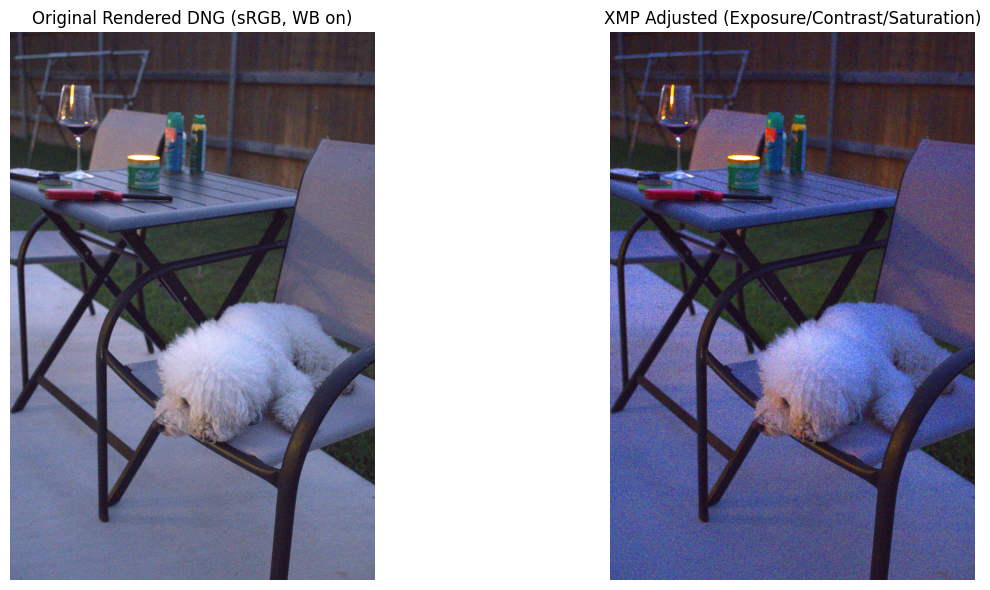

In [ ]:
import rawpy
import cv2
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import json
import os
from PIL import Image as PILImage
from IPython.display import Image, display
import io

INPUT_FILE = "input/DSC_6450.dng"

# --- Step 1: Load image from DNG using rawpy (correct color) ---
with rawpy.imread(INPUT_FILE) as raw:
    rgb = raw.postprocess(
        output_bps=8,
        use_camera_wb=True,            # enables better color rendering
        no_auto_bright=False,          # allow auto brightness like a normal JPEG
        gamma=(2.222, 4.5)             # sRGB gamma
        # gamma=(1, 1)             # sRGB gamma
    )

# Convert BGR to RGB (OpenCV to standard RGB)
# rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)

# --- Step 2: Load XMP metadata using exiftool ---
def get_xmp_crs_fields(dng_path):
    result = subprocess.run(
        ["exiftool", "-XMP:all", "-json", dng_path],
        stdout=subprocess.PIPE,
        text=True
    )
    return json.loads(result.stdout)[0]

metadata = get_xmp_crs_fields(INPUT_FILE)

# --- Step 3: Apply basic Adobe-style exposure/contrast adjustments ---
def apply_exposure_contrast(img, meta):
    exposure = meta.get("Exposure2012", 0.0)
    contrast = meta.get("Contrast2012", 0)

    img = img.astype(np.float32)
    img *= 2 ** exposure

    if contrast != 0:
        factor = (259 * (contrast + 255)) / (255 * (259 - contrast))
        img = 128 + factor * (img - 128)

    return np.clip(img, 0, 255).astype(np.uint8)

# --- Step 4: Apply global saturation adjustment ---
def apply_saturation(img, meta, saturation=None):
    if not saturation:
        saturation = meta.get("Saturation", 0)
    if saturation == 0:
        return img

    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float32)
    img_hsv[..., 1] *= 1 + saturation / 100.0
    img_hsv[..., 1] = np.clip(img_hsv[..., 1], 0, 255)
    return cv2.cvtColor(img_hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)

# --- Step 5: Apply adjustments ---
adjusted = apply_exposure_contrast(rgb, metadata)
adjusted = apply_saturation(adjusted, metadata, 100)

# --- Step 6: Display side-by-side ---
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.imshow(rgb)
plt.title("Original Rendered DNG (sRGB, WB on)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(adjusted)
plt.title("XMP Adjusted (Exposure/Contrast/Saturation)")
plt.axis("off")
plt.tight_layout()
plt.show()



In [ ]:
# # --- Step 7: Display final adjusted JPG in notebook using PIL ---
# pil_img = PILImage.fromarray(rgb)
# buf = io.BytesIO()
# pil_img.save(buf, format='PNG')
# buf.seek(0)
# display(Image(data=buf.getvalue()))
